In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
N = int(1e6)
z = np.random.uniform(-3, 1, N)

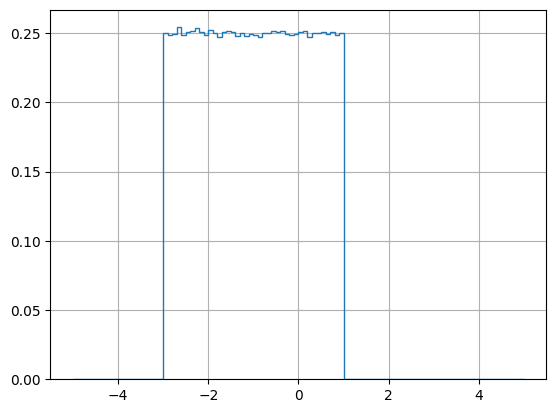

In [3]:
plt.hist(z, range=(-5, 5), density=True, histtype='step', bins=100)
plt.grid(True)

In [4]:
def h0(x):
    if x>0:
        return 9*x
    else:
        return x
h = np.vectorize(h0)


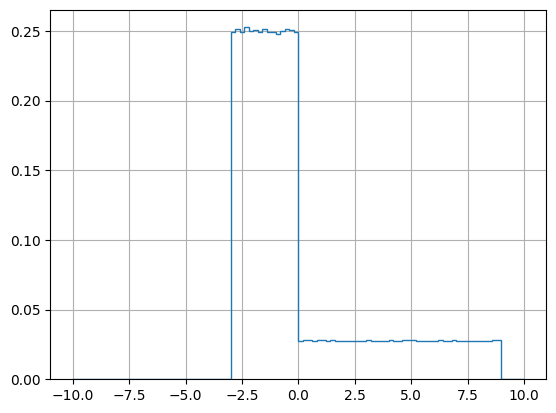

In [5]:
x = h(z)
plt.hist(x, range=(-10, 10), density=True, histtype='step', bins=100)
plt.grid(True)

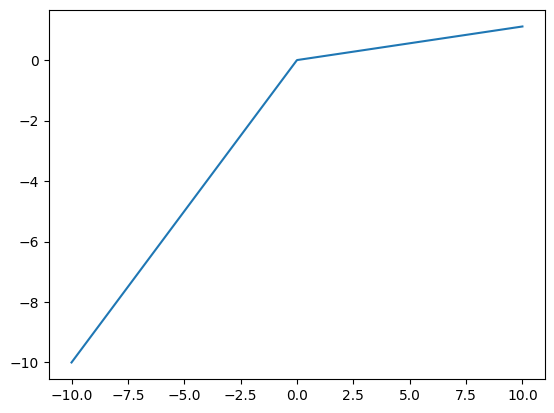

In [6]:
def g0(x):
    if x > 0:
        return 1/9*x
    else:
        return 1*x
g = np.vectorize(g0)
plt.plot(np.linspace(-10, 10, 1000), g(np.linspace(-10, 10, 1000)))

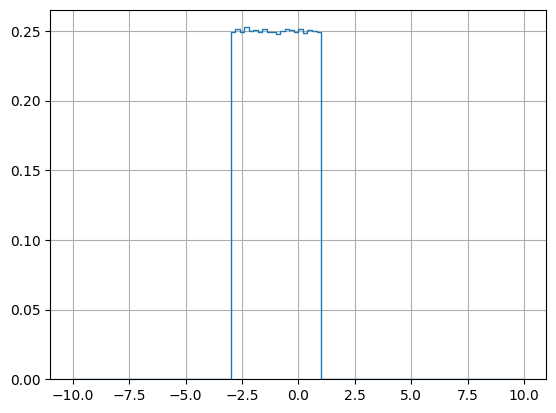

In [7]:
y = g(x)
plt.hist(y, range=(-10, 10), density=True, histtype='step', bins=100)
plt.grid(True)

(-0.0018006573191680204, 8.998957359135924)

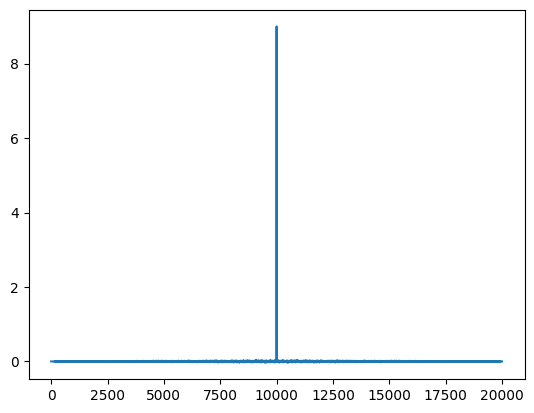

In [8]:
phi_xx = sum(list(map(lambda x: np.correlate(x, x, mode='full'), x.reshape((100, int(N/100))))))/(N-1)

plt.plot(phi_xx)
np.mean(x), np.var(x)

In [21]:
import functools
from scipy import signal

def moving_average(x, Ts, Taverage):
    window_length = int(Taverage/Ts)
    window = np.ones(window_length)
    # y = signal.convolve(x, window, mode='full', method='auto')/Taverage#*np.sqrt(Ts)/Taverage
    # y = signal.lfilter(window, [1], x)/(Taverage/np.sqrt(Ts))
    y = signal.lfilter(window, [1], x)/Taverage
    y = y[:len(x)]
    return y

def delay(x, Ts, Td):
    delay_samples = int(Td/Ts)
    delta = np.concatenate((np.zeros(int(Td/Ts)), [1]))
    return signal.lfilter(delta, [1], x)

def apply_batch(x, fcn):
    return np.array(list(map(fcn, x)))

def align_batch(*signals):
    desired_length = min([x.shape[1] for x in signals])
    return (x[:,:desired_length] for x in signals)

def ccf_batch(x, y, Ts):
    x, y = align_batch(x, y)
    Nbatch, N = x.shape
    lags = signal.correlation_lags(N, N, mode='full')
    phi_xy = sum(list(map(lambda f, g: signal.correlate(f, g, mode='full')/(N-abs(lags)), x, y)))/Nbatch
    tau = Ts*lags
    return phi_xy, tau

def acf_batch(x, Ts):
    return ccf_batch(x, x, Ts)

def random_process(power, Tges, Nbatch, Ts, process=np.random.randn):
    N = int(Tges/Ts)
    # return np.sqrt(power/Ts)*np.random.randn(Nbatch, N)
    return np.sqrt(power)*np.random.randn(Nbatch, N)
    
Tges = 200000
Ts = 250e-3
Nbatch=1
x = random_process(
    power=4,
    Tges=Tges,
    Ts=Ts,
    Nbatch=Nbatch
)
print(f'{np.var(x)=}')

y = apply_batch(x, functools.partial(moving_average, Ts=Ts, Taverage=2))
z = apply_batch(x, functools.partial(delay, Ts=Ts, Td=2))
1/Tges*np.sum(y**2)*Ts/Nbatch*Ts


np.var(x)=3.9994543608995095


2.0043397621846153

max(phi_xx)=3.9994545217544313


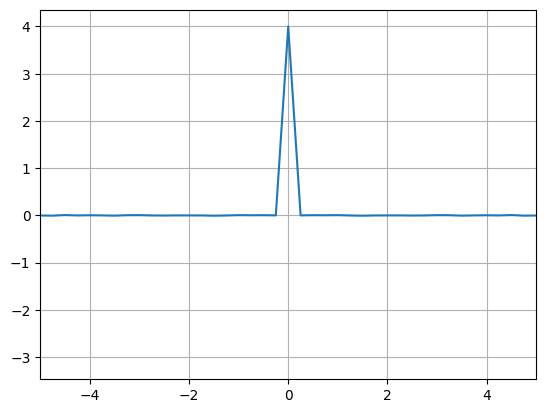

In [22]:

phi_xx, tau = acf_batch(x, Ts)
plt.plot(tau, phi_xx)
plt.grid(True)
# plt.xticks(range(-10, 12, 2))
plt.xlim([-5, 5])
np.var(y), 1/Nbatch*np.sum(1/Tges*np.sum(y*y, axis=1)*Ts, axis=0)
print(f'{max(phi_xx)=}')

max(phi_yy)=8.017359048738463


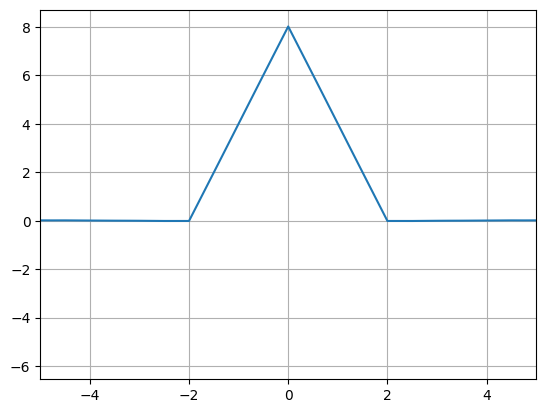

In [23]:

phi_yy, tau = ccf_batch(y, y, Ts)
plt.plot(tau, phi_yy)
plt.grid(True)
plt.xlim([-5, 5])
print(f'{max(phi_yy)=}')


(-5.0, 5.0)

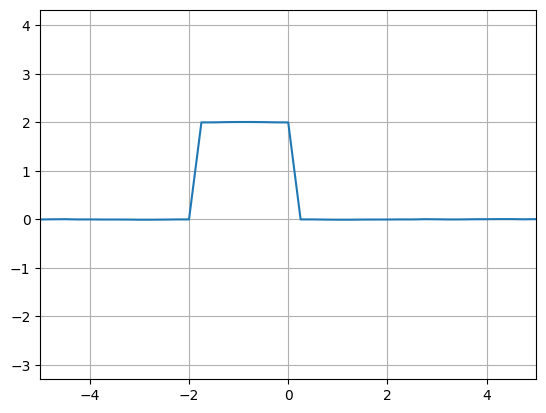

In [24]:
phi_xy, tau = ccf_batch(x, y, Ts)
plt.plot(tau, phi_xy)
plt.grid(True)
plt.xlim([-5, 5])
# print(f'{max(phi_xy)=}')